# Implementation - 1

In [64]:
import pandas as pd

data = {'Name'  : ['Anna', 'Bob', 'Charlie', 'Diana', 'Eric'],
        'Age'   : [20, 34, 23, None, 33],
        'Gender': ['f', 'm', 'm', 'f', 'm'],
        'Job'   : ['Programmer', 'Writer', 'Cook', 'Programmer', 'Teacher']}

df = pd.DataFrame(data)

In [65]:
df

,Name,Age,Gender,Job
0,Anna,20.0,f,Programmer
1,Bob,34.0,m,Writer
2,Charlie,23.0,m,Cook
3,Diana,NaN,f,Programmer
4,Eric,33.0,m,Teacher


Preprocessing Pipeline:

* Droop Name Feature
* Impute Ages
* Turn Gender into Binary/Numeric
* One Hot Encode Jobs

In [66]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder

# Drop Name Feature
df = df.drop(columns='Name')

# Impute Ages
imputer = SimpleImputer(strategy='mean')
df['Age'] = imputer.fit_transform(df[['Age']])

# Numeric Gender
gender_dct = {'m': 0, 'f': 1}
df['Gender']  = [gender_dct[g] for g in df['Gender']] 

# OneHotEncode Jobs
encoder = OneHotEncoder()
matrix = encoder.fit_transform(df[['Job']]).toarray()

column_names = ['Programmer', 'Writer', 'Cook', 'Teacher']

for i in range(len(matrix.T)):
    df[column_names[i]] = matrix.T[i]
    
df = df.drop(columns='Job')

In [67]:
df

,Age,Gender,Programmer,Writer,Cook,Teacher
0,20.0,1,0.0,1.0,0.0,0.0
1,34.0,0,0.0,0.0,0.0,1.0
2,23.0,0,1.0,0.0,0.0,0.0
3,27.5,1,0.0,1.0,0.0,0.0
4,33.0,0,0.0,0.0,1.0,0.0


In [68]:
from sklearn.base import BaseEstimator, TransformerMixin

class NameDropper(BaseEstimator, TransformerMixin):
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return X.drop(columns='Name')
    
class AgeImputer(BaseEstimator, TransformerMixin):

    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        imputer = SimpleImputer(strategy='mean')
        X['Age'] = imputer.fit_transform(X[['Age']])
        return X
    
class FeatureEncoder(BaseEstimator, TransformerMixin):

    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        gender_dct = {'m': 0, 'f': 1}
        X['Gender']  = [gender_dct[g] for g in X['Gender']] 

        encoder = OneHotEncoder()
        matrix = encoder.fit_transform(X[['Job']]).toarray()

        column_names = ['Programmer', 'Writer', 'Cook', 'Teacher']

        for i in range(len(matrix.T)):
            X[column_names[i]] = matrix.T[i]

        return X.drop(columns='Job')

In [69]:
data = {'Name'  : ['Fiona', 'Gerald', 'Hans', 'Isabella', 'Jacob'],
        'Age'   : [20, 34, None, None, 33],
        'Gender': ['f', 'm', 'm', 'f', 'm'],
        'Job'   : ['Writer', 'Programmer', 'Programmer', 'Programmer', 'Teacher']}

df2 = pd.DataFrame(data)
df2

,Name,Age,Gender,Job
0,Fiona,20.0,f,Writer
1,Gerald,34.0,m,Programmer
2,Hans,NaN,m,Programmer
3,Isabella,NaN,f,Programmer
4,Jacob,33.0,m,Teacher


In [70]:
dropper = NameDropper()
imp = AgeImputer()
enc = FeatureEncoder()

enc.fit_transform(imp.fit_transform(dropper.fit_transform(df2)))

,Age,Gender,Programmer,Writer,Cook
0,20.0,1,0.0,0.0,1.0
1,34.0,0,1.0,0.0,0.0
2,29.0,0,1.0,0.0,0.0
3,29.0,1,1.0,0.0,0.0
4,33.0,0,0.0,1.0,0.0


In [71]:
from sklearn.pipeline import Pipeline

pipe = Pipeline([
    ('dropper', NameDropper()),
    ('imputer', AgeImputer()),
    ('encoder', FeatureEncoder())
])

pipe.fit_transform(df2)

,Age,Gender,Programmer,Writer,Cook
0,20.0,1,0.0,0.0,1.0
1,34.0,0,1.0,0.0,0.0
2,29.0,0,1.0,0.0,0.0
3,29.0,1,1.0,0.0,0.0
4,33.0,0,0.0,1.0,0.0


# Implementation - 2

In [72]:
import numpy as np

train_df = pd.read_csv("../../C_Datasets/california_housing_train.csv").iloc[:, :-1]
test_df = pd.read_csv("../../C_Datasets/california_housing_test.csv").iloc[:, :-1]

train_df = train_df.dropna()
test_df = test_df.dropna()

In [73]:
train_df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0
1,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0
2,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0
3,-122.25,37.85,52.0,919.0,213.0,413.0,193.0,4.0368,269700.0
4,-122.25,37.84,52.0,2535.0,489.0,1094.0,514.0,3.6591,299200.0


In [74]:
test_df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
0,-118.15,33.92,28.0,1038.0,252.0,912.0,245.0,2.5875,161200.0
1,-122.49,37.86,52.0,2175.0,510.0,809.0,503.0,4.5398,442000.0
2,-119.81,36.80,38.0,2252.0,325.0,777.0,314.0,6.1575,160100.0
3,-121.43,37.75,30.0,1912.0,451.0,1065.0,388.0,2.1424,125000.0
4,-120.99,37.69,25.0,2773.0,384.0,1060.0,381.0,6.4788,199400.0


In [75]:
X_train, y_train = train_df.to_numpy()[:, :-1], train_df.to_numpy()[:, -1]
X_test, y_test = test_df.to_numpy()[:, :-1], test_df.to_numpy()[:, -1]

In [76]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((16335, 8), (16335,), (4098, 8), (4098,))

In [77]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, FunctionTransformer
from copy import deepcopy

std_scaler = StandardScaler().fit(X_train[:, :2])
min_max_scaler = MinMaxScaler().fit(X_train[:, 2:])

def preprocessor(X):
    A = np.copy(X)
    A[:, :2] = std_scaler.transform(X[:, :2])
    A[:, 2:] = min_max_scaler.transform(X[:, 2:])
    return A

In [78]:
preprocessor(X_test)

array([[ 0.70803345, -0.80163678,  0.52941176, ...,  0.02547717,
         0.04012498,  0.14397043],
       [-1.45707621,  1.03770048,  1.        , ...,  0.02259032,
         0.08255221,  0.27860995],
       [-0.12009605,  0.5428534 ,  0.7254902 , ...,  0.02169343,
         0.0514718 ,  0.39017393],
       ...,
       [-1.21761708,  0.77627184,  0.47058824, ...,  0.04753496,
         0.08748561,  0.52301348],
       [-0.63393544,  0.87430758,  0.37254902, ...,  0.03517475,
         0.05245848,  0.23419677],
       [-0.77860867,  0.98168006,  0.58823529, ...,  0.0145744 ,
         0.02598257,  0.13516365]])

In [79]:
preprocessor_transformer = FunctionTransformer(preprocessor)
preprocessor_transformer

FunctionTransformer(func=<function preprocessor at 0x00000203D4E21300>)

In [80]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression

p1 = Pipeline([
    ('Scaler', preprocessor_transformer),
    ('Linear Regression', LinearRegression()) 
])

print(p1)
p1

Pipeline(steps=[('Scaler',
                 FunctionTransformer(func=<function preprocessor at 0x00000203D4E21300>)),
                ('Linear Regression', LinearRegression())])


Pipeline(steps=[('Scaler',
                 FunctionTransformer(func=<function preprocessor at 0x00000203D4E21300>)),
                ('Linear Regression', LinearRegression())])

In [81]:
from sklearn.metrics import mean_absolute_error

def fit_and_print(p, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test):
    p.fit(X_train, y_train)
    train_preds = p.predict(X_train)
    test_preds = p.predict(X_test)
    print('Training error: ' + str(mean_absolute_error(train_preds, y_train)))
    print('Test error:     ' + str(mean_absolute_error(test_preds, y_test)))    

In [82]:
fit_and_print(p1)

Training error: 50861.859930035884
Test error:     50813.548838187045


In [83]:
from sklearn.neighbors import KNeighborsRegressor as KNR

p2 = Pipeline([
    ('Scaler', preprocessor_transformer),
    ('KNN Regression', KNR(n_neighbors=7)) 
])

fit_and_print(p2)

Training error: 30536.210485810487
Test error:     34855.689639545424


In [84]:
from sklearn.ensemble import RandomForestRegressor as RFR

p3 = Pipeline([
    ('Scaler', preprocessor_transformer),
    ('Random Forest', RFR(n_estimators=10, max_depth=7)) 
])

fit_and_print(p3)

Training error: 41363.045370990665
Test error:     42115.22196025478


# Implementation - 3

### Main Consept in Pipelines

**Transformer**: filtering or modifying the data

    - Classes that implement both fit() and transform()
    - Example: Generate a new data matrix consisting of all polynomial combinations
    
**Estimator**: learning form data

    - Classes that implement both fit() and predict()
    - Example: Train a linear regression model on the input features
    
### What is "pipeline"?

- Sequentially apply a list of transformers and a final estimator.

![resim.png](attachment:resim.png)

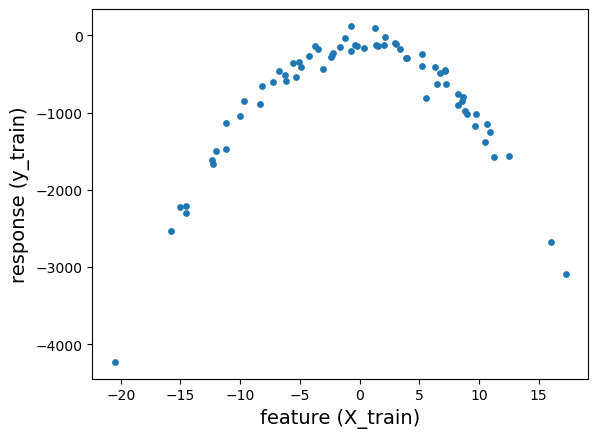

In [85]:
# importing libraries
import numpy as np
import matplotlib.pyplot as plt

# creating a dataset
X_train = 10 * np.random.normal(0, 1, 70)
y_train = 10 * (-X_train ** 2) + np.random.normal(-100, 100, 70)

# plotting dataset
plt.scatter(X_train, y_train, s=15)
plt.xlabel('feature (X_train)', fontsize=14)
plt.ylabel('response (y_train)', fontsize=14)

plt.show()

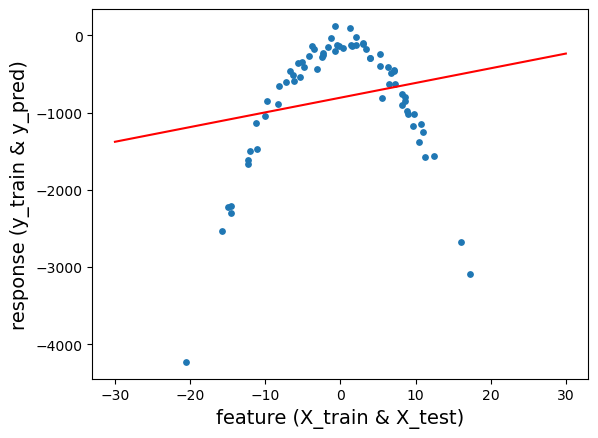

In [86]:
from sklearn.linear_model import LinearRegression

# Training Model
lm = LinearRegression()
lm.fit(X_train.reshape(-1, 1), y_train.reshape(-1, 1))

X_test = np.linspace(-30, 30, 100)

# Predictions
y_pred = lm.predict(X_test.reshape(-1, 1))

# plotting predictions
plt.scatter(X_train, y_train, s=15)
plt.plot(X_test, y_pred, color='r')
plt.xlabel('feature (X_train & X_test)', fontsize=14)
plt.ylabel('response (y_train & y_pred)', fontsize=14)

plt.show()

**Using Pipeline**

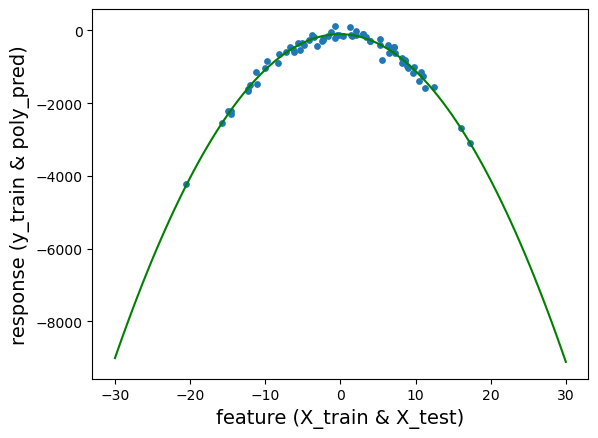

In [87]:
# importing libraries for polynomial transform
from sklearn.preprocessing import PolynomialFeatures

# creating pipeline
from sklearn.pipeline import Pipeline

# creating pipeline and fitting it on data
pipe = Pipeline([('transformer', PolynomialFeatures(degree=2)),
                 ('estimator', LinearRegression())])

pipe.fit(X_train.reshape(-1, 1), y_train.reshape(-1, 1))

# predictions
poly_pred = pipe.predict(X_test.reshape(-1, 1))

# plotting predictions
plt.scatter(X_train, y_train, s=15)
plt.plot(X_test, poly_pred, color='g')
plt.xlabel('feature (X_train & X_test)', fontsize=14)
plt.ylabel('response (y_train & poly_pred)', fontsize=14)

plt.show()